# Part 2 - Machine Learning Modeling
This notebook focus on the following ML modeling steps:
* Data preparation:
    * Split into training, validation and testing data sets.
    * One-hot encoding. 
* Modeling and Evaluation:
    * Training models: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting (XGBoost).
    * Evaluation on trained models using confusion matrix, AUC scoring.
    * Identify important features.
* Hyperparameter-tuning on best model.
* Save the final model
    * Test final model on unseen data (test data set).
    * Train and test final model on training + validation data sets, evaluate on test data set.
    * Save final model and final `DictVectorizer`. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.feature_extraction import DictVectorizer

### Potential issue with loading XGBoost

There might be potential issues with importing `xgboost` in the following code block due to your local Operating System. 

For example, this notebook was ran on Mac OS X and required additional setup in terminal: `brew install libomp` to fix the import issue.

Please follow the suggestions given in the error message and fix accordingly.

In [2]:
from xgboost import XGBClassifier

### Load cleaned dataset
Refer to notebook **part_1_preprocessing.ipynb** for the data cleaning, EDA and feature engineering steps.

In [3]:
file = "../data/heart_clean.csv"
df = pd.read_csv(file)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Cholesterol_Level
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,High
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,Normal
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,High
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,Borderline high
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,Normal


In [4]:
df.shape

(917, 13)

### 2.1 Data Preparation

Split dataset into training/validation/test sets (60%/20%/20%)

In [5]:
y = df['HeartDisease']
X = df.drop(columns=['HeartDisease'])

In [6]:
df_full_train, df_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, shuffle=True, stratify=y)

df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=11, shuffle=True, 
                                                  stratify=y_full_train)

Verify that the split sets' sizes tally with original dataset size

In [7]:
print(df_train.shape, df_val.shape, df_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

assert y_train.shape[0] + y_val.shape[0] + y_test.shape[0] == df.shape[0]

(549, 12) (184, 12) (184, 12)
(549,) (184,) (184,)


Perform one-hot encoding using `DictVectorizer`

In [8]:
def encode_data(df_train):
    '''
    Trains a DictVectorizer model using the training dataset to perform one-hot encoding.
    Returns trained DictVectorizer model, encoded training dataset
    '''
    dict_train = df_train.to_dict(orient='records')    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dict_train)
    return dv, X_train
    

In [9]:
dv, X_train = encode_data(df_train)
dict_val = df_val.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)

In [10]:
features = dv.get_feature_names_out()
features

array(['Age', 'ChestPainType=ASY', 'ChestPainType=ATA',
       'ChestPainType=NAP', 'ChestPainType=TA', 'Cholesterol',
       'Cholesterol_Level=Borderline high', 'Cholesterol_Level=High',
       'Cholesterol_Level=Normal', 'ExerciseAngina=N', 'ExerciseAngina=Y',
       'FastingBS', 'MaxHR', 'Oldpeak', 'RestingBP', 'RestingECG=LVH',
       'RestingECG=Normal', 'RestingECG=ST', 'ST_Slope=Down',
       'ST_Slope=Flat', 'ST_Slope=Up', 'Sex=F', 'Sex=M'], dtype=object)

### 2.2 ML Modeling and Evaluation

### 2.2.1 Train models

* Train 4 candidate models: `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier`, `XGBClassifier`.
    * To ensure the tree models are compared on a similar level, the hyperparameter `max_depth` is set to be the same instead of using their default values.
    * For reproducibility, random states are set (except for `LogisticRegression` which doesn't have such hyperparameter)
    * Set `solver='liblinear'` for `LogisticRegression` since the default `solver='lbfgs'` throws an error due to the small dataset.
* Evaluate the candidate models on training and validation dataset.
    * Compute the False Positive Rates, True Positive Rates for each model-dataset pair using Confusion Matrix.
    * Compute the AUC scores for each model-dataset pair. 

In [11]:
logreg = LogisticRegression(solver='liblinear', random_state=11)
dt = DecisionTreeClassifier(max_depth=3, random_state=11)
rf = RandomForestClassifier(max_depth=3, random_state=11)
xgb = XGBClassifier(max_depth=3, seed=11, eval_metric='auc')

models = {"LogisticRegression": logreg, 
          "DecisionTreeClassifier": dt,
          "RandomForestClassifier": rf,
         "XGBClassifier": xgb}

In [12]:
def train_model(model, X_train, y_train, X_val, y_val):
    '''
    train model and predict on training and validation sets
    '''
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)[:,1]
    val_pred = model.predict_proba(X_val)[:,1]
    return model, train_pred, val_pred

In [13]:
results = {}
trained_models = {}
for k, m in models.items():
    trained_model, train_pred, val_pred = train_model(m, X_train, y_train, X_val, y_val)
    # store trained model
    trained_models[k] = trained_model
    
    # compute false positive rate, true positive rate on training and validation set
    fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
    fpr_val, tpr_val, _ = roc_curve(y_val, val_pred)
    
    # compute auc scoring on training and validation set
    AUC_train = roc_auc_score(y_train, train_pred) 
    AUC_val = roc_auc_score(y_val, val_pred)

    # save evaluation results
    results[k] = (fpr_train, tpr_train, fpr_val, tpr_val, AUC_train, AUC_val)

### 2.2.2 Confusion Matrix
Plot confusion matrix of each candidate model used for validation dataset evaluation.

In [14]:
def plot_confusion_matrix(subtitle, model):
    fig, ax = plt.subplots(figsize=(3,3))
    fig.suptitle(f"Confusion Matrix for {subtitle}")
    cmd = ConfusionMatrixDisplay.from_estimator(
        model, X_val, y_val, display_labels=['No', 'Yes'], ax=ax)
    cmd.ax_.set_xlabel("Predicted Heart Disease")
    cmd.ax_.set_ylabel("Actual Heart Disease")
    plt.show()

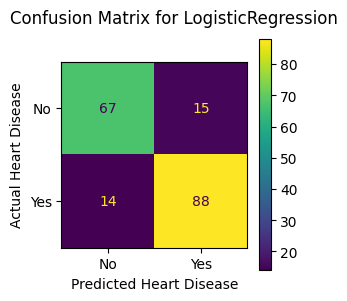

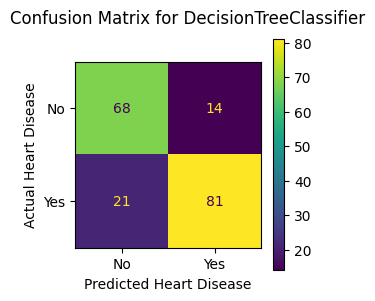

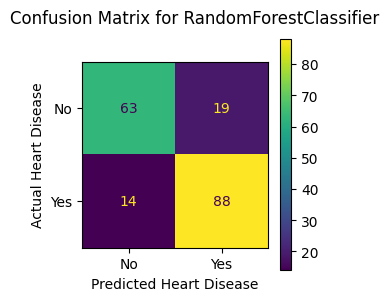

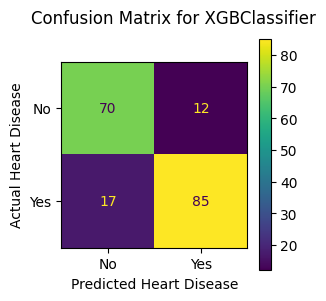

In [15]:
for k,v in trained_models.items():
    plot_confusion_matrix(k, v)

### Summary of 2.2.2 Modeling and Evaluation

Looking at the confusion matrix, take note that:
* The diagonal axis represents all "prediction = actual" values, it reflects the true negatives on top left and true positives on bottom right.
* The off-diagonal axis represents all prediction errors, it reflects the false positives on top right and false negatives on bottom left.

The focus here should be on the **off-diagonal axis**, and moreover, we want to place more importance on **reducing the false negatives**. 

**Reason**:
* It is better to be predicted to potentially have heart disease, be given a thorough medical examination, and turns out to be a false alarm afterwards. This applies to **false positives**.
* It is much worse to be predicted to be healthy but in fact not so, which could lead to a failure in early prevention of cause-of-death due to heart disease. This applies to **false negatives**.

**Conclusion**:
* Both `LogisticRegression` and `RandomForestClassifier` models produced the lowest number of false negatives, followed by `XGBClassifier` and lastly `DecisionTreeClassifier`.

### 2.2.3 ROC AUC Scores
Compare ROC AUC scores between candidate models. As per ML-Zoomcamp Lesson 4.6, the AUC should be maximised to have a higher proportion of correctly classified positives (true positive rate) over the incorrectly classified positives (false positive rate).

In [16]:
# Compile the evaluation results from 2.2.1
df_eval = pd.DataFrame(results, index=['train_fpr', 'train_tpr',  
                                       'val_fpr', 'val_tpr', 
                                       'train_auc_score', 'val_auc_score'])
df_eval = df_eval.T
df_eval.reset_index(inplace=True)
df_eval.rename(columns={'index':'model'}, inplace=True)
df_eval.head()

,model,train_fpr,train_tpr,val_fpr,val_tpr,train_auc_score,val_auc_score
0,LogisticRegression,"[0.0, 0.0, 0.0, 0.0040650406504065045, 0.00406...","[0.0, 0.0033003300330033004, 0.204620462046204...","[0.0, 0.0, 0.0, 0.012195121951219513, 0.012195...","[0.0, 0.00980392156862745, 0.35294117647058826...",0.941198,0.887255
1,DecisionTreeClassifier,"[0.0, 0.0, 0.036585365853658534, 0.06910569105...","[0.0, 0.013201320132013201, 0.6402640264026402...","[0.0, 0.07317073170731707, 0.0975609756097561,...","[0.0, 0.5098039215686274, 0.5490196078431373, ...",0.926776,0.876973
2,RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00406504...","[0.0, 0.006600660066006601, 0.0561056105610561...","[0.0, 0.0, 0.0, 0.012195121951219513, 0.012195...","[0.0, 0.00980392156862745, 0.21568627450980393...",0.9394,0.901124
3,XGBClassifier,"[0.0, 0.0, 0.0, 0.016260162601626018, 0.016260...","[0.0, 0.0033003300330033004, 0.990099009900990...","[0.0, 0.0, 0.0, 0.012195121951219513, 0.012195...","[0.0, 0.00980392156862745, 0.12745098039215685...",0.999812,0.903276


Plot the ROC AUC plots of each model by:
* training ROC curve
* validation ROC curve

In [17]:
def plot_roc_curve(data, title, fpr, tpr, score): 
    plt.figure(figsize=(4,4))
    _ = data.apply(lambda row: sns.lineplot(x=row[fpr], \
                                               y=row[tpr], \
                                               label=f"{row['model']}={row[score]:.4f}", \
                                               errorbar=None), axis=1)
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(linestyle='-', color='0.8')
    plt.show()

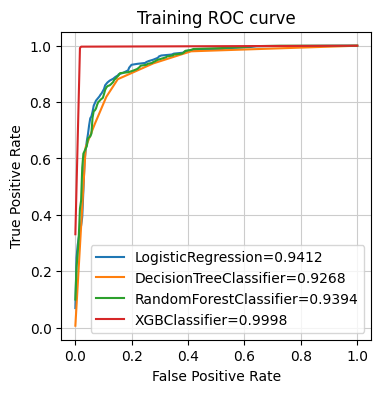

In [18]:
plot_roc_curve(df_eval, "Training ROC curve", 'train_fpr', 'train_tpr', 'train_auc_score')

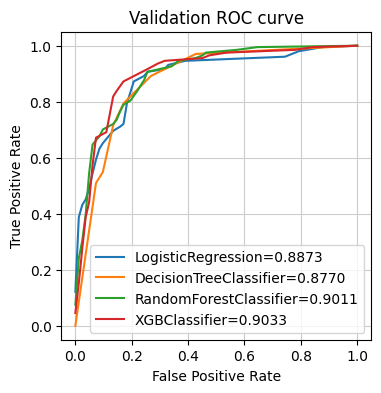

In [19]:
plot_roc_curve(df_eval, "Validation ROC curve", 'val_fpr', 'val_tpr', 'val_auc_score')

### Summary of 2.2.3 ROC AUC Scores

Ranked by best to worst validation AUC score:
* `XGBClassifier`: clearly overfitted on training dataset with a near perfect training AUC score, and tops the validation AUC score. Difference between training and validation AUC: 0.0965
* `RandomForestClassifier`: The training AUC score and validation AUC score only differs by 0.0383
* `LogisticRegression`: The training AUC score and validation AUC score differs by 0.0539
* `DecisionTreeClassifier`: The training AUC score and validation AUC score differs by 0.0498

### 2.2.4 Identifying Top 10 Important Features
Only look at `DecisionTreeClassifier`, `RandomForestClassifier`, `XGBClassifier`.

In [20]:
features_dt = dict(zip(features, trained_models['DecisionTreeClassifier'].feature_importances_.round(5)))
sorted(features_dt.items(), key=lambda x: x[1], reverse=True)[:10]

[('ST_Slope=Up', np.float64(0.60503)),
 ('ChestPainType=ASY', np.float64(0.22889)),
 ('Oldpeak', np.float64(0.0978)),
 ('MaxHR', np.float64(0.04025)),
 ('Sex=F', np.float64(0.02803)),
 ('Age', np.float64(0.0)),
 ('ChestPainType=ATA', np.float64(0.0)),
 ('ChestPainType=NAP', np.float64(0.0)),
 ('ChestPainType=TA', np.float64(0.0)),
 ('Cholesterol', np.float64(0.0))]

In [21]:
features_rf = dict(zip(features, trained_models['RandomForestClassifier'].feature_importances_.round(5)))
sorted(features_rf.items(), key=lambda x: x[1], reverse=True)[:10]

[('ST_Slope=Up', np.float64(0.21149)),
 ('ST_Slope=Flat', np.float64(0.14302)),
 ('ChestPainType=ASY', np.float64(0.1395)),
 ('ExerciseAngina=N', np.float64(0.10006)),
 ('ExerciseAngina=Y', np.float64(0.08614)),
 ('MaxHR', np.float64(0.07356)),
 ('Oldpeak', np.float64(0.05858)),
 ('Sex=M', np.float64(0.03629)),
 ('ChestPainType=ATA', np.float64(0.03004)),
 ('Sex=F', np.float64(0.02763))]

In [22]:
features_xgb = dict(zip(features, trained_models['XGBClassifier'].feature_importances_.round(5)))
sorted(features_xgb.items(), key=lambda x: x[1], reverse=True)[:10]

[('ST_Slope=Up', np.float32(0.43281)),
 ('ChestPainType=ASY', np.float32(0.12163)),
 ('ExerciseAngina=N', np.float32(0.06638)),
 ('FastingBS', np.float32(0.06405)),
 ('Sex=F', np.float32(0.04047)),
 ('ST_Slope=Flat', np.float32(0.0358)),
 ('Oldpeak', np.float32(0.03111)),
 ('ST_Slope=Down', np.float32(0.02625)),
 ('RestingECG=LVH', np.float32(0.026)),
 ('ChestPainType=ATA', np.float32(0.02414))]

### Summary for 2.2.3 Identifying Top 10 Important Features
* `DecisionTreeClassifier`, `RandomForestClassifier`, `XGBClassifier` have `ST_Slope=Up` as most important feature.
* Other common similarities: `ChestPainType=ASY`, `Oldpeak`, `Sex=F`.
* Strictly speaking, `DecisionTreeClassifier` only has 5 important features as all features after the top 5 scored 0 in importance.
* If we only look at `RandomForestClassifier`, `XGBClassifier`, they shared `ST_Slope=Up`, `ST_Slope=Flat`, `ChestPainType=ASY`, `ExerciseAngina=N`, `Oldpeak`, `ChestPainType=ATA`, `Sex=F` in their top 10 features.

As the current validation AUC scores are generally doing reasonably well, reiteration over feature engineering and/or elimination from the dataset is unnecessary to improve the models. The hyperparameter-tuning step should be sufficient to improve it further.

### 2.3 Hyperparameter Tuning

From 4 candidate models, it's narrowed down to 2 best models `RandomForestClassifier`, `XGBClassifier` due to:
* `RandomForestClassifier` has lowest number of **false negatives** in confusion matrix and the second best model seen in ROC Curves.
* `XGBClassifier` has second lowest number of **false negatives** in confusion matrix and the best model seen in ROC Curves.

Now, perform Grid Search CV on both `RandomForestClassifier`, `XGBClassifier` to finetune the hyperparameters:
* Fit the finetuned hyperparameters on respective models.
* Evaluate the validation dataset with Confusion Matrix, ROC curve and AUC scoring.
* Decide on the final model.

### 2.3.1 Grid Search CV on RandomForestClassifier

In [23]:
parameters = {'max_depth' : [2, 3, 4, 5],
              'n_estimators': [100, 200, 300],
              'min_samples_leaf': [1, 2, 3]
            }
rf = RandomForestClassifier(random_state=11)
gcv_rf = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc', n_jobs=-1)
gcv_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=11), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [24]:
gcv_rf.best_params_

{'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 300}

### 2.3.2 Grid Search CV on XGBClassifier

In [25]:
parameters = {'eta' : [0.005, 0.01, 0.05, 0.1, 1],
              'max_depth' : [2, 3, 4, 5],
              'n_estimators': [100, 200, 300],
              'min_child_weight': [1, 2, 3]
            }
xgb = XGBClassifier(random_state=11)
gcv_xgb = GridSearchCV(xgb, parameters, cv=5, scoring='roc_auc', n_jobs=-1)
gcv_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=11, ...),
             n_jobs=-1,
             param_grid={'eta': [0.005, 0.01, 0.05, 0.1, 1],
                         'max_depth': [2, 3, 4, 5],
                         'min_child_weight': [1, 2, 3],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [26]:
gcv_xgb.best_params_

{'eta': 0.05, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 100}

### 2.3.3 Fit and Evaluate Finetuned Models on Validation Dataset
For each finetuned model,
* Train on training data.
* Plot confusion matrix after evaluated on validation dataset.
* Plot ROC curve.

In [27]:
def plot_roc_curve_best(model, X_train, X_val, title): 
    # Compute false positive rate, true positive rate for training and validation predictions
    train_pred = model.predict_proba(X_train)[:,1]
    val_pred = model.predict_proba(X_val)[:,1]
    
    fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
    fpr_val, tpr_val, _ = roc_curve(y_val, val_pred)

    # AUC scoring on training and validation dataset
    AUC_train = roc_auc_score(y_train, train_pred) 
    AUC_val = roc_auc_score(y_val, val_pred)

    plt.figure(figsize=(4,4))
    sns.lineplot(x=fpr_train, y=tpr_train, label=f"Training AUC score={AUC_train:.4f}", errorbar=None)
    sns.lineplot(x=fpr_val, y=tpr_val, label=f"Validation AUC score={AUC_val:.4f}", errorbar=None)
    plt.title(f"{title} ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(linestyle='-', color='0.8')
    plt.show()

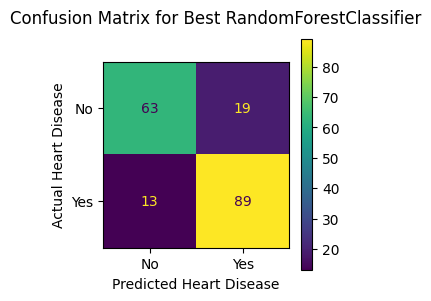

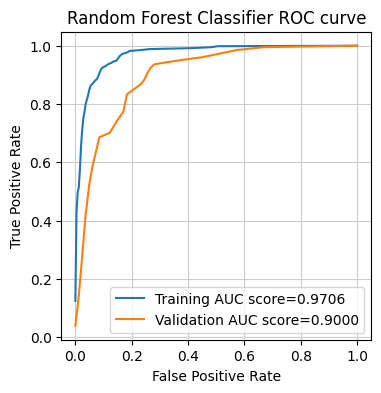

In [28]:
rf_best = RandomForestClassifier(random_state=11, **gcv_rf.best_params_)
rf_best.fit(X_train, y_train)
plot_confusion_matrix("Best RandomForestClassifier", rf_best)
plot_roc_curve_best(rf_best, X_train, X_val, "Random Forest Classifier")

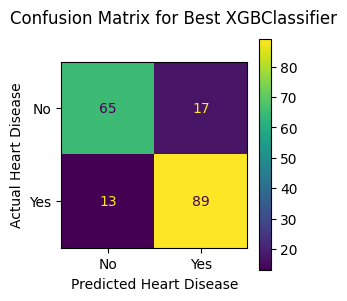

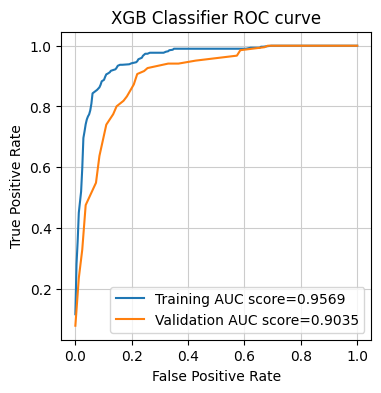

In [29]:
xgb_best = XGBClassifier(random_state=11, **gcv_xgb.best_params_)
xgb_best.fit(X_train, y_train)
plot_confusion_matrix("Best XGBClassifier", xgb_best)
plot_roc_curve_best(xgb_best, X_train, X_val, "XGB Classifier")

### Summary on 2.3 Hyperparameter Tuning

The performance of finetuned models are compared with the old models at Section **2.2.1 Confusion Matrix** and **2.2.2 ROC AUC Score**:
* `RandomForestClassifier`:
    *  False Positive Rate reduced from 14 to 13, while True Positive Rate increase from 88 to 89.
    *  Training AUC score increased from 0.9394 to 0.9706
    *  Validation AUC score decreased from 0.9011 to 0.9000, likely due to overfitting.
    *  Overall not much improvement.
* `XGBClassifier`:
    *  False Positive Rate reduced from 17 to 13, while True Positive Rate increase from 85 to 89.
    *  Training AUC score decreased from 0.9998 to 0.9569, overfitting reduced.
    *  Validation AUC score increased from 0.9033 to 0.9035.
    *  Overall slightly better improvement compared to `RandomForestClassifier`.

As per above, it is decided that the final model would be an `XGBClassifier` model.

### 2.4 Save final model to pickle 


### 2.4.1 Test final model on unseen data
Before the final model is saved, the best model is tested on the testing dataset which was never used previously.

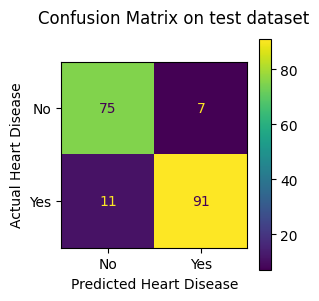

In [30]:
fig, ax = plt.subplots(figsize=(3,3))
fig.suptitle(f"Confusion Matrix on test dataset")
cmd = ConfusionMatrixDisplay.from_estimator(
    xgb_best, X_test, y_test, display_labels=['No', 'Yes'], ax=ax)
cmd.ax_.set_xlabel("Predicted Heart Disease")
cmd.ax_.set_ylabel("Actual Heart Disease")
plt.show()

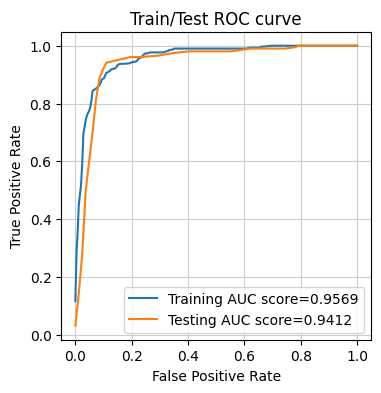

In [31]:
# Compute false positive rate, true positive rate for training and validation predictions
train_pred = xgb_best.predict_proba(X_train)[:,1]
test_pred = xgb_best.predict_proba(X_test)[:,1]

fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, test_pred)

# AUC scoring on training and validation dataset
AUC_train = roc_auc_score(y_train, train_pred) 
AUC_test = roc_auc_score(y_test, test_pred)

plt.figure(figsize=(4,4))
sns.lineplot(x=fpr_train, y=tpr_train, label=f"Training AUC score={AUC_train:.4f}", errorbar=None)
sns.lineplot(x=fpr_test, y=tpr_test, label=f"Testing AUC score={AUC_test:.4f}", errorbar=None)
plt.title(f"Train/Test ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(linestyle='-', color='0.8')
plt.show()

The results are rather impressive as not only the false negative and false positive numbers are low, the testing AUC score is also very close to the training AUC score! (Diff: 0.0157)

Now what happens if the best model is trained on **training + validation dataset** instead?
How will it perform on the unseen test data?

**Note**
* `df_full_train` was the original training + validation dataset in **2.1 Data Preparation**.
* Recreate `DictVectorizer` with `df_full_train`.

In [32]:
dv_full, X_full_train = encode_data(df_full_train)
dict_test = df_test.to_dict(orient='records')
X_test = dv_full.transform(dict_test)

Recreate XGBClassifier best model to train on training + validation dataset

In [33]:
xgb_best = XGBClassifier(random_state=11, **gcv_xgb.best_params_)
xgb_best.fit(X_full_train, y_full_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

Evaluate the new final model on test data set using Confusion Matrix and ROC curve.

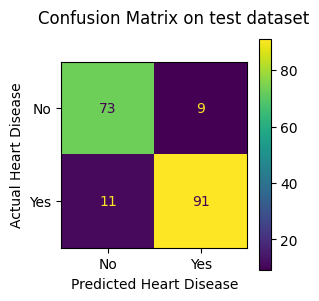

In [34]:
fig, ax = plt.subplots(figsize=(3,3))
fig.suptitle(f"Confusion Matrix on test dataset")
cmd = ConfusionMatrixDisplay.from_estimator(
    xgb_best, X_test, y_test, display_labels=['No', 'Yes'], ax=ax)
cmd.ax_.set_xlabel("Predicted Heart Disease")
cmd.ax_.set_ylabel("Actual Heart Disease")
plt.show()

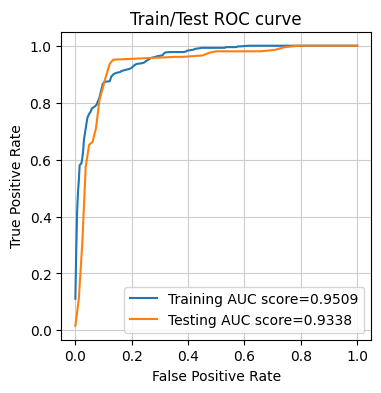

In [35]:
# Compute false positive rate, true positive rate for full training and test predictions
train_pred = xgb_best.predict_proba(X_full_train)[:,1]
test_pred = xgb_best.predict_proba(X_test)[:,1]

fpr_train, tpr_train, _ = roc_curve(y_full_train, train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, test_pred)

# AUC scoring on training and validation dataset
AUC_train = roc_auc_score(y_full_train, train_pred) 
AUC_test = roc_auc_score(y_test, test_pred)

plt.figure(figsize=(4,4))
sns.lineplot(x=fpr_train, y=tpr_train, label=f"Training AUC score={AUC_train:.4f}", errorbar=None)
sns.lineplot(x=fpr_test, y=tpr_test, label=f"Testing AUC score={AUC_test:.4f}", errorbar=None)
plt.title(f"Train/Test ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(linestyle='-', color='0.8')
plt.show()

The results are still pretty good although false positive numbers increased slightly, both AUC scores dropped a little but still the difference between the two AUC scores are still reasonably small!(Diff: 0.0171)

### Summary for 2.4.1 Test final model on unseen data
Regardless of just using training or training + validation data to fit the final model, this model generally performs really well as the false negatives numbers were low, and there isn't overfitting issues as observed in the small difference between training and test AUC scores.

Since the original dataset size is pretty small (917 records), the **final model** to be saved and used in future predictions would be trained on the complete dataset (training + validation + test) instead.

### 2.4.2 Save the final model and DictVectorizer

In [36]:
# create DictVectorizer on full dataset (without target) and transform the data
dv_final, X_transformed = encode_data(X)

In [37]:
# create final model
xgb_final = XGBClassifier(random_state=11, **gcv_xgb.best_params_)
# fit on full dataset
xgb_final.fit(X_transformed, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [38]:
final_model = "../model/heart_disease_model.bin"

In [39]:
f_out = open(final_model, 'wb') 
pickle.dump((dv_final, xgb_final), f_out)
f_out.close()